# Cleaning, Analyzing, and Visualizing Survey Data in Python

## A tutorial using `pandas`, `matplotlib`, and `seaborn` to produce digestible insights from dirty data

If you work in data at a D2C startup, there's a good chance you will be asked to look at survey data at least once. And since SurveyMonkey is one of the most popular survey platforms out there, there's a good chance it'll be SurveyMonkey data.

The way SurveyMonkey exports data is not necessarily ready for analysis right out of the box, but it's pretty close. Here I'll demonstrate a few examples of questions you might want to ask of your survey data, and how to extract those answers quickly. We'll even write a few functions to make our lives easier when plotting future questions.

We'll be using `pandas`, `matplotlib`, and `seaborn` to make sense of our data. I used [Mockaroo](https://mockaroo.com/) to generate this data; specifically, for the survey question fields, I used "Custom List" and entered in the appropriate fields. You could achieve the same effect by using `random.choice` in the `random` module, but I found it easier to let Mockaroo create the whole thing for me. I then tweaked the data in Excel so that it mirrored the structure of a SurveyMonkey export.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
survey_data = pd.read_csv('MOCK_DATA.csv')
survey_data.head()

,id,What is your gender?,What is your age?,What was the most important consideration for you in choosing this product?,Unnamed: 4,Unnamed: 5,Unnamed: 6,How interested are you in the following benefits?,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,gender,age,Location,Price,Positive Reviews,Personalization,Custom dashboard templates,SQL tutorials,More drag-and-drop features,More ready-made formulas
1,1.0,Female,35,Location,NaN,NaN,NaN,Neutral,Very interested,Somewhat interested,Very interested
2,2.0,Female,34,Location,NaN,NaN,NaN,Somewhat uninterested,Very interested,Neutral,Somewhat interested
3,3.0,Female,19,NaN,Price,NaN,NaN,Somewhat uninterested,Neutral,Somewhat interested,Very interested
4,4.0,Female,47,NaN,Price,NaN,NaN,Somewhat uninterested,Neutral,Neutral,Somewhat interested


Your first reaction to this might be "Ugh. It's horrible." I mean, the column names didn't read in properly, there are a ton of NaNs, instead of numerical representations like 0/1 or 1/2/3/4/5 we have the actual text answers in each cell...And should we actually be reading this in with a MultiIndex?

But don't worry, it's not as bad as you might think. And we're going to ignore MultiIndexes in this post. (Nobody really likes working with them anyway.) The team needs those insights ASAP--so we'll come up with some hacky solutions.

First order of business: we've been asked to find how the answers to these questions vary by age group. But `age` is just an age--we don't have a column for age groups! Well, luckily for us, we can pretty easily define a function to create one.

In [3]:
def age_group(age):
    
    """Creates an age bucket for each participant using the age variable.
        Meant to be used on a DataFrame with .apply()."""
    
    # Convert to an int, in case the data is read in as an "object" (aka string)
    age = int(age)
    
    if age < 30:
        bucket = '<30'
    
    # Age 30 to 39 ('range' excludes upper bound)
    if age in range(30, 40):
        bucket = '30-39'
        
    if age in range(40, 50):
        bucket = '40-49'
        
    if age in range(50, 60):
        bucket = '50-59'
   
    if age >= 60:
        bucket = '60+'

    return bucket 

But if we try to run it like this, we'll get an error! That's because we have that first row, and its value for age is the word "age" instead of a number. Since the first step is to convert each age to an `int`, this will fail.

We need to remove that row from the DataFrame, but it'll be useful for us later when we rename columns, so we'll save it as a separate variable. 

In [4]:
# Save it as headers, and then later we can access it via slices like a list
headers = survey_data.loc[0]

In [5]:
# .drop() defaults to axis=0, which refers to dropping items row-wise
survey_data = survey_data.drop(0)
survey_data.head(3)

,id,What is your gender?,What is your age?,What was the most important consideration for you in choosing this product?,Unnamed: 4,Unnamed: 5,Unnamed: 6,How interested are you in the following benefits?,Unnamed: 8,Unnamed: 9,Unnamed: 10
1,1.0,Female,35,Location,NaN,NaN,NaN,Neutral,Very interested,Somewhat interested,Very interested
2,2.0,Female,34,Location,NaN,NaN,NaN,Somewhat uninterested,Very interested,Neutral,Somewhat interested
3,3.0,Female,19,NaN,Price,NaN,NaN,Somewhat uninterested,Neutral,Somewhat interested,Very interested


You will notice that, since removing `headers`, we've now lost some information when looking at the survey data by itself. Ideally, you will have a list of the questions and their options that were asked in the survey, provided to you by whoever wants the analysis. If not, you should keep a separate way to reference this info in a document or note that you can look at while working.

OK, now let's apply the `age_group` function to get our `age_group` column.

In [6]:
survey_data['age_group'] = survey_data['What is your age?'].apply(age_group)

survey_data['age_group'].head(3)

1    30-39
2    30-39
3      <30
Name: age_group, dtype: object

Great. Next, let's subset the data to focus on just the first question. How do the answers to this first question vary by age group?

In [7]:
# Subset the columns from when the question "What was the most..." is asked, 
# through to all the available answers. Easiest to use .iloc for this
survey_data.iloc[:5, 3:7]

,What was the most important consideration for you in choosing this product?,Unnamed: 4,Unnamed: 5,Unnamed: 6
1,Location,NaN,NaN,NaN
2,Location,NaN,NaN,NaN
3,NaN,Price,NaN,NaN
4,NaN,Price,NaN,NaN
5,NaN,Price,NaN,NaN


In [8]:
# Next, assign it to a separate variable corresponding to your question
important_consideration = survey_data.iloc[:, 3:7]

Great. We have the answers in a variable now. But when we go to plot this data, it's not going to look very good, because of the misnamed columns. Let's write up a quick function to make renaming the columns simple:

In [9]:
def rename_columns(df, new_names_list):
    
    """Takes a DataFrame that needs to be renamed and a list of the new
        column names, and returns the renamed DataFrame. Make sure the 
        number of columns in the df matches the list length exactly,
        or function will not work as intended."""
    
    rename_dict = dict(zip(df.columns, new_names_list))
    df = df.rename(mapper=rename_dict, axis=1)
    
    return df

Remember `headers` from earlier? We can use it to create our `new_names_list` for renaming.

In [10]:
headers[3:7].values

array(['Location', 'Price', 'Positive Reviews', 'Personalization'],
      dtype=object)

It's already an array, so we can just pass it right in, or we can rename it first for readability.

In [11]:
ic_col_names = headers[3:7].values

important_consideration = rename_columns(important_consideration, ic_col_names)

# Now tack on age_group from the original DataFrame so we can use .groupby
# (You could also use pd.concat, but I find this easier)
important_consideration['age_group'] = survey_data['age_group']

important_consideration.head(3)

,Location,Price,Positive Reviews,Personalization,age_group
1,Location,NaN,NaN,NaN,30-39
2,Location,NaN,NaN,NaN,30-39
3,NaN,Price,NaN,NaN,<30


Isn't that so much nicer to look at? Don't worry, we're almost to the part where we get some insights.

In [12]:
consideration_grouped = important_consideration.groupby('age_group').agg('count')

consideration_grouped

,Location,Price,Positive Reviews,Personalization
age_group,,,,
30-39,25,14,23,17
40-49,23,24,19,23
50-59,17,22,17,21
60+,37,38,50,38
<30,20,22,24,26


Notice how `groupby` and other aggregation functions ignore NaNs automatically. That makes our lives significantly easier.

Let's say we also don't really care about analyzing under-30 customers right now, so we'll plot only the other age groups.

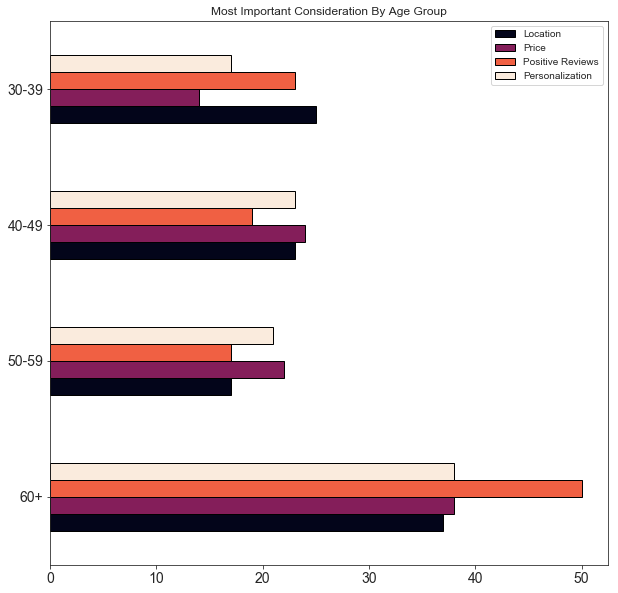

In [13]:
consideration_grouped[:-1].sort_index(ascending=False).plot(
    kind='barh',
    figsize=(10, 10),
    cmap='rocket',
    edgecolor='black',
    fontsize=14,
    title='Most Important Consideration By Age Group'
    ).yaxis.label.set_visible(False)

plt.savefig('sdbp_photos/consideration_by_age_large.png')

OK, this is all well and good, but the 60+ group has more people in it than the other groups, and so it's hard to make a fair comparison. What do we do? We can plot each age group in a separate plot, and then compare the distributions.

"But wait," you might think. "I don't really want to write the code for 4 different plots."

Well of course not! Who has time for that? Let's write another function to do it for us.

In [14]:
def plot_counts_by_age_group(groupby_count_obj, age_group, ax=None):
    
    """Takes a count-aggregated groupby object, an age group, and an 
    (optional) AxesSubplot, and draws a barplot for that group."""
    
    sort_order = groupby_count_obj.loc[age_group].sort_index().index

    sns.barplot(y = groupby_count_obj.loc[age_group].index, 
                x = groupby_count_obj.loc[age_group].values, 
                order = sort_order, 
                palette = 'rocket', edgecolor = 'black', 
                ax = ax
                ).set_title("Age {}".format(age_group))

I believe it was [Jenny Bryan](https://twitter.com/JennyBryan?), in her wonderful talk "Code Smells and Feels," who first tipped me off to the following:

**If you find yourself copying and pasting code and just changing a few values, you really ought to just write a function.**

This has been a great guide for me in deciding when it is and isn't worth it to write a function for something. A rule of thumb I like to use is that if I would be copying and pasting more than 3 times, I write a function.

There are also benefits other than convenience to this approach, such as that it: 
* reduces the possibility for error (when copying and pasting, it's easy to accidentally forget to change a value)
* makes for more readable code
* builds up your personal toolbox of functions
* forces you to think at a higher level of abstraction

(All of which improve your programming skills and make the people who need to read your code happier!)

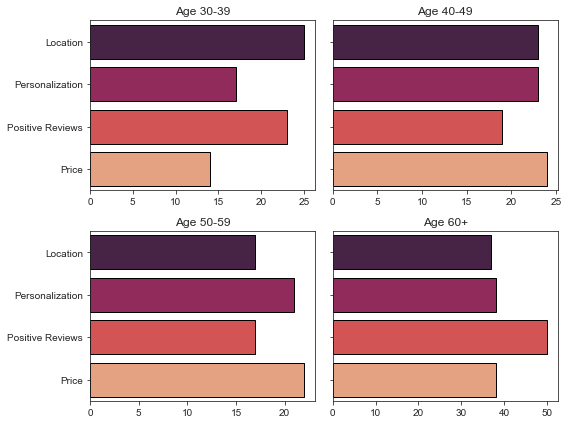

In [15]:
# Setup for the 2x2 subplot grid
# Note we don't want to share the x axis since we have counts
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharey=True)

# ax.flatten() avoids having to explicitly reference a subplot index in ax
# Use consideration_grouped.index[:-1] because we're not plotting the under-30s
for subplot, age_group in zip(ax.flatten(), list(consideration_grouped.index)[:-1]):
    plot_counts_by_age_group(consideration_grouped, age_group, ax=subplot)
    
plt.savefig('sdbp_photos/consideration_by_age.png')
plt.tight_layout()

This is, of course, generated data from a uniform distribution, and we would thus not expect to see any significant differences between groups. Hopefully your own survey data will be more interesting. 

Next, let's address another format of question. In this one, we need to see how interested each age group is in a given benefit. Happily, these questions are actually easier to deal with than the former type. Let's take a look:

In [16]:
benefits = survey_data.iloc[:, 7:]
benefits.head(3)

,How interested are you in the following benefits?,Unnamed: 8,Unnamed: 9,Unnamed: 10,age_group
1,Neutral,Very interested,Somewhat interested,Very interested,30-39
2,Somewhat uninterested,Very interested,Neutral,Somewhat interested,30-39
3,Somewhat uninterested,Neutral,Somewhat interested,Very interested,<30


And look, since this is a small DataFrame, `age_group` is appended already and we won't have to add it.

In [17]:
ben_col_names = headers[7:].values

benefits = rename_columns(benefits, ben_col_names)

benefits.head(3)

,Custom dashboard templates,SQL tutorials,More drag-and-drop features,More ready-made formulas,age_group
1,Neutral,Very interested,Somewhat interested,Very interested,30-39
2,Somewhat uninterested,Very interested,Neutral,Somewhat interested,30-39
3,Somewhat uninterested,Neutral,Somewhat interested,Very interested,<30


Cool. Now we have the subsetted data, but we can't just aggregate it by count this time like we could with the other question - the last question had NaNs that would be excluded to give the true count for that response, but with this one, we would just get the number of responses for each age group overall:

In [18]:
benefits.groupby('age_group').agg('count')

,Custom dashboard templates,SQL tutorials,More drag-and-drop features,More ready-made formulas
age_group,,,,
30-39,79,79,79,79
40-49,89,89,89,89
50-59,77,77,77,77
60+,163,163,163,163
<30,92,92,92,92


This is definitely not what we want! The point of the question is to understand how interested the different age groups are, and we need to preserve that information. All this tells us is how many people in each age group responded to the question.

So what do we do? One way to go would be to re-encode these responses numerically. But what if we want to preserve the relationship on an even more granular level? If we encode numerically, we can take the median and average of each age group's level of interest. But what if what we're really interested in is the specific percentage of people per age group who chose each interest level? It'd be easier to convey that info in a barplot, with the text preserved.

That's what we're going to do next. And--you guessed it--it's time to write another function.

In [19]:
order = ['Not Interested at all', 'Somewhat uninterested',
        'Neutral', 'Somewhat interested', 'Very interested']

def plot_benefit_question(df, col_name, age_group, order=order, 
                          palette='Spectral', ax=None):
    
    """Takes a relevant DataFrame, the name of the column (benefit) we want info on,
        and an age group, and returns a plot of the answers to that benefit question."""
    
    reduced_df = df[[col_name, 'age_group']]

    # Gets the relative frequencies (percentages) for "this-age-group" only
    data_to_plot = reduced_df[reduced_df['age_group'] == age_group][col_name].value_counts(normalize=True)
    
    sns.barplot(y = data_to_plot.index, 
                x = data_to_plot.values, 
                order = order, 
                ax = ax,
                palette = palette, 
                edgecolor = 'black'
                ).set_title('Age {}: {}'.format(age_group, col_name))

**Quick note to new learners:** Most people won't say this explicitly, but let me be clear on how visualizations are often made. Generally speaking, it is a highly iterative process. Even the most experienced data scientists don't just write up a plot with all of these specifications off the top of their head. 

Generally, you start with `.plot(kind='bar')`, or similar depending on the plot you want, and then you change size, color maps, get the groups properly sorted using `order=`, specify whether the labels should be rotated, and set x- or y-axis labels invisible, and more, depending on what you think is best for whoever will be using the visualizations.

So don't be intimidated by the long blocks of code you see when people are making plots. They're usually created over a span of minutes while testing out different specifications, not by writing perfect code from scratch in one go.

---

Now we can plot another 2x2 for each benefit broken out by age group. But we'd have to do that for all 4 benefits! Again: who has time for that? Instead, we'll loop over each benefit, and each age group within each benefit, using a couple of `for` loops. But if you're interested, I'd challenge you to refactor this into a function if you happen to have many questions that are formatted like this.

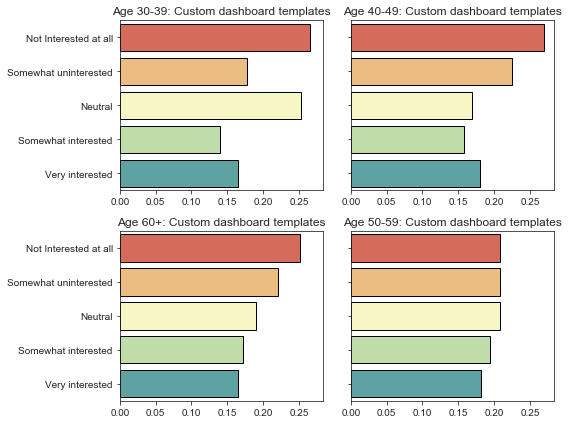

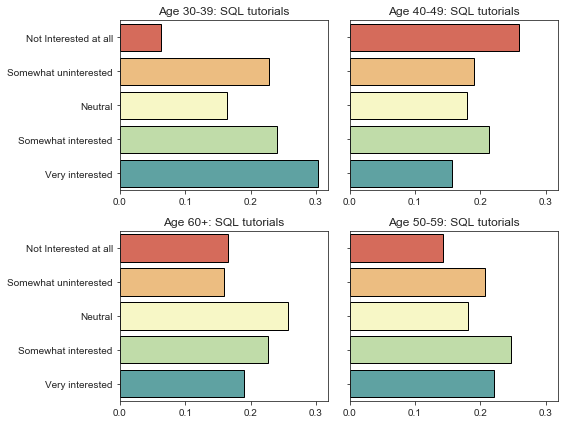

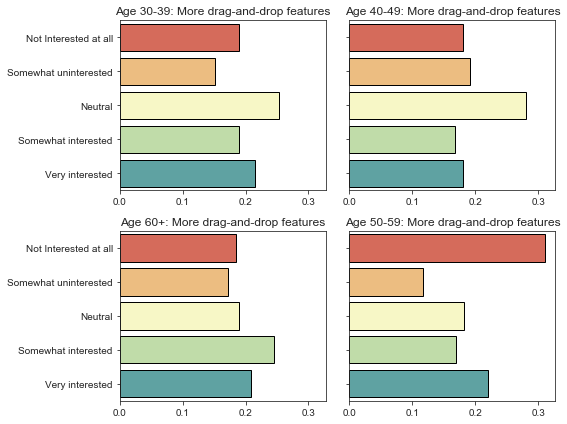

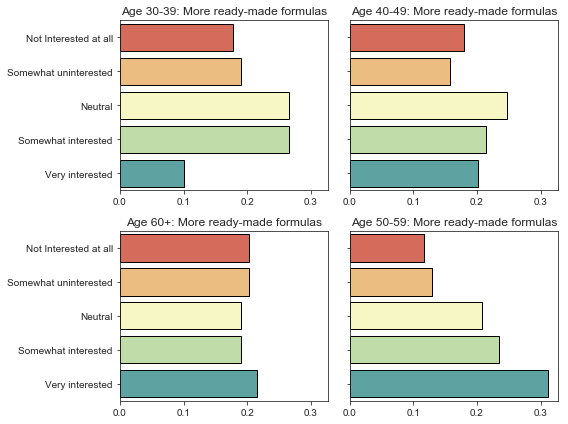

In [20]:
# Exclude age_group from the list of benefits
all_benefits = list(benefits.columns[:-1])

# Exclude under-30s
buckets_except_under30 = [group for group in benefits['age_group'].unique()
                         if group != '<30']

for benefit in all_benefits:
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), 
                           sharey=True, sharex=True)

    for a, age_group in zip(ax.flatten(), buckets_except_under30):
        plot_benefit_question(benefits, benefit, 
                              age_group=age_group, ax=a)
        
        # Keeps x-axis tick labels for each group of plots
        a.xaxis.set_tick_params(which='both', labelbottom=True)
        
        # Suppresses displaying the question along the y-axis
        a.yaxis.label.set_visible(False)
    
    plt.savefig('sdbp_photos/{}_interest_by_age.png'.format(benefit))
    plt.tight_layout()

Success! And if you wanted to export each individual set of plots, you would simply add the line `plt.savefig('{}_interest_by_age.png'.format(benefit))`, and `matplotlib` would automatically save a beautifully sharp rendering of each set of plots. This makes it especially easy for folks on other teams to use your findings; you can simply export them to a plots folder, and people can browse the images and be able to drag and drop them right into a PowerPoint presentation or other report.   

---

Let's do one more example: numerically encoding the benefits, as we mentioned earlier. Then we can generate a heatmap of the correlations between interest in different benefits.

In [21]:
def encode_interest(interest):
    """Takes a string indicating interest and encodes it to an ordinal
    (numerical) variable."""
        
    if interest == 'Not Interested at all':
        x = 1
        
    if interest == 'Somewhat uninterested':
        x = 2
    
    if interest == 'Neutral':
        x = 3
        
    if interest == 'Somewhat interested':
        x = 4
        
    if interest == 'Very interested':
        x = 5

    return x  

benefits_encoded = benefits.iloc[:, :-1].copy()

# Map the ordinal variable
for column in benefits.iloc[:, :-1].columns:
    benefits_encoded[column] = benefits[column].map(encode_interest)

benefits_encoded.head(3)

,Custom dashboard templates,SQL tutorials,More drag-and-drop features,More ready-made formulas
1,3,5,4,5
2,2,5,3,4
3,2,3,4,5


And lastly, we'll generate the correlation matrix and plot the correlations.

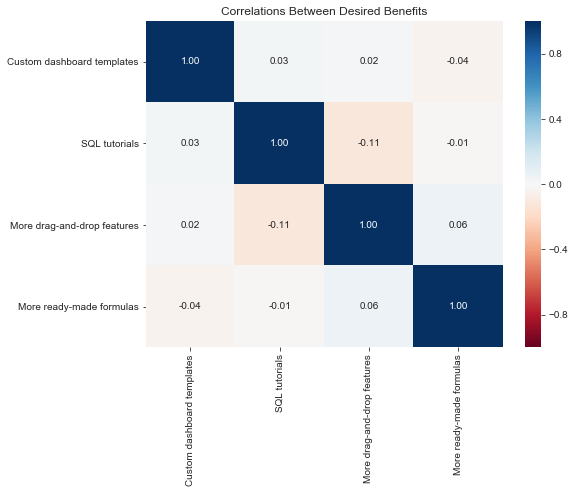

In [22]:
# Use Spearman instead of default Pearson, since these 
# are ordinal variables!
corr_matrix = benefits_encoded.corr(method='spearman')

# Setup
fig, ax = plt.subplots(figsize=(8, 6))

# vmin and vmax control the range of the colormap
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
           vmin=-1, vmax=1)

plt.title("Correlations Between Desired Benefits")
plt.savefig('sdbp_photos/corrs.png')
plt.show()

Again, since the data is randomly generated, we would expect there to be little to no correlation, and that is indeed what we find. (It is funny to note that SQL tutorials are slightly negatively correlated with drag-and-drop features, which is actually what we might expect to see in real data!)

Let's do one last type of plot, one that's closely related to the heatmap: the clustermap. Clustermaps make correlations especially informative in analyzing survey responses, because they use hierarchical clustering to (in this case) group benefits together by how closely related they are. So instead of eyeballing the heatmap for which individual benefits are positively or negatively associated, which can get a little crazy when you start to have 10+ benefits, the plot will be segmented into clusters, which is a little easier to look at.

You can also easily change the linkage type used in the calculation, if you're familiar with the mathematical details of hierarchical clustering. Some of the available options are 'single', 'average', and 'ward'--I won't get into the details, but 'ward' is generally a safe bet when starting out.

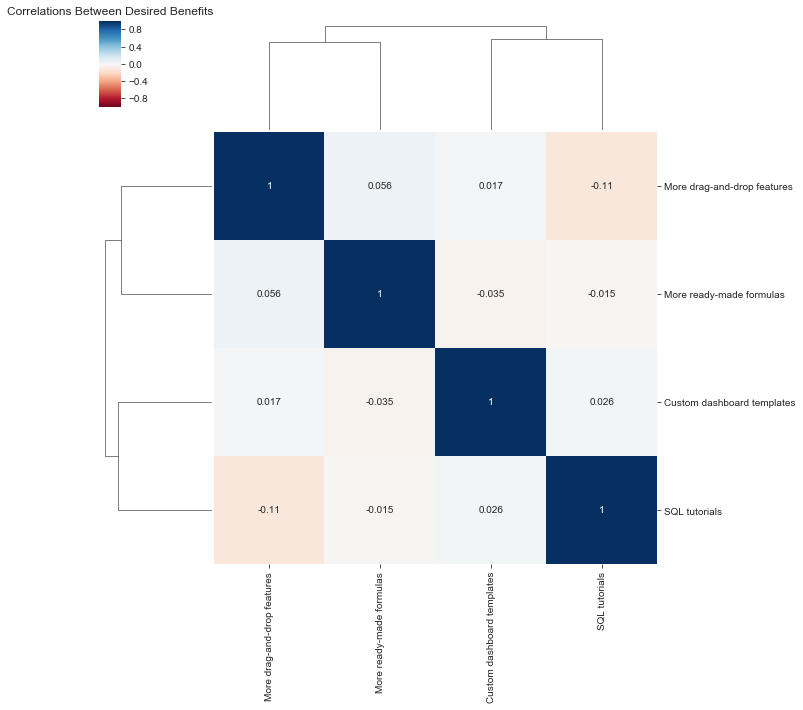

In [23]:
sns.clustermap(corr_matrix, method='ward', cmap='RdBu', annot=True,
               vmin=-1, vmax=1)

plt.title("Correlations Between Desired Benefits")
plt.savefig('sdbp_photos/clusts.png')
plt.show()

A quick assessment of this shows that the clustering algorithm believes drag-and-drop features and ready-made formulas cluster together, while custom dashboard templates and SQL tutorials form another cluster. Since the correlations are so weak, you can see that the "height" of when the benefits link together to form a cluster is very tall. (This means you should probably not base any business decisions on this finding!) Hopefully the example is illustrative despite the weak relationships.

---

I hope you enjoyed this quick tutorial about working with survey data and writing functions to quickly generate visualizations of your findings! If you think you know an even more efficient way of doing things, feel free to let me know in the comments - this is just what I came up with when I needed to produce insights as quickly as possible. 